In [60]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [63]:
import pandas as pd
import os

In [64]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [65]:
X, y = skds.fetch_openml("diabetes", return_X_y=True)
X = StandardScaler().fit_transform(X)


In [66]:
y[y==['tested_positive']] = 1
y[y==['tested_negative']] = 0

In [67]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(500, 8)
(268, 8)


In [68]:
indices=np.arange(250)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:250]
x_train=np.concatenate((np.array(x_neg[0:250])[indices],x_pos)).reshape(-1,8)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [69]:
x_test = x_neg[250:500].reshape(-1,8)
y_test = y_neg[250:500].reshape(-1,1)

# Projection model

In [70]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [71]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [72]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(268, 8)
Size: 10 Bits - FPR: 0.996000 - Time Taken to create filter(sec): 0.108625 



Size: 20 Bits - FPR: 0.868000 - Time Taken to create filter(sec): 0.088951 



Size: 30 Bits - FPR: 0.864000 - Time Taken to create filter(sec): 0.162554 



Size: 40 Bits - FPR: 0.888000 - Time Taken to create filter(sec): 0.086303 



Size: 50 Bits - FPR: 0.824000 - Time Taken to create filter(sec): 0.084459 



Size: 60 Bits - FPR: 0.804000 - Time Taken to create filter(sec): 0.096253 



Size: 70 Bits - FPR: 0.776000 - Time Taken to create filter(sec): 0.087980 



Size: 80 Bits - FPR: 0.816000 - Time Taken to create filter(sec): 0.089487 



Size: 90 Bits - FPR: 0.784000 - Time Taken to create filter(sec): 0.095144 



Size: 100 Bits - FPR: 0.684000 - Time Taken to create filter(sec): 0.090798 



Size: 110 Bits - FPR: 0.676000 - Time Taken to create filter(sec): 0.091512 



Size: 120 Bits - FPR: 0.700000 - Time Taken to create filter(sec): 0.104697 



Size: 13

Size: 1030 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.106388 



Size: 1040 Bits - FPR: 0.188000 - Time Taken to create filter(sec): 0.121873 



Size: 1050 Bits - FPR: 0.224000 - Time Taken to create filter(sec): 0.098845 



Size: 1060 Bits - FPR: 0.232000 - Time Taken to create filter(sec): 0.097212 



Size: 1070 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.097028 



Size: 1080 Bits - FPR: 0.196000 - Time Taken to create filter(sec): 0.124783 



Size: 1090 Bits - FPR: 0.136000 - Time Taken to create filter(sec): 0.098686 



Size: 1100 Bits - FPR: 0.136000 - Time Taken to create filter(sec): 0.094457 



Size: 1110 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.100500 



Size: 1120 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.098959 



Size: 1130 Bits - FPR: 0.160000 - Time Taken to create filter(sec): 0.124737 



Size: 1140 Bits - FPR: 0.144000 - Time Taken to create filter(sec): 0.097882 



Size: 1150 Bits - FPR: 0.184

Size: 2060 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.138758 



Size: 2070 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.137156 



Size: 2080 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.138190 



Size: 2090 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.138785 



Size: 2100 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.163179 



Size: 2110 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.163607 



Size: 2120 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.138121 



Size: 2130 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.136471 



Size: 2140 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.144222 



Size: 2150 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.152578 



Size: 2160 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.144418 



Size: 2170 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.175266 



Size: 2180 Bits - FPR: 0.076

Size: 70 Bits - FPR: 0.772000 - Time Taken to create filter(sec): 0.114208 



Size: 80 Bits - FPR: 0.864000 - Time Taken to create filter(sec): 0.291727 



Size: 90 Bits - FPR: 0.832000 - Time Taken to create filter(sec): 0.223215 



Size: 100 Bits - FPR: 0.812000 - Time Taken to create filter(sec): 0.206020 



Size: 110 Bits - FPR: 0.692000 - Time Taken to create filter(sec): 0.228690 



Size: 120 Bits - FPR: 0.768000 - Time Taken to create filter(sec): 0.210547 



Size: 130 Bits - FPR: 0.712000 - Time Taken to create filter(sec): 0.211322 



Size: 140 Bits - FPR: 0.636000 - Time Taken to create filter(sec): 0.216125 



Size: 150 Bits - FPR: 0.700000 - Time Taken to create filter(sec): 0.142982 



Size: 160 Bits - FPR: 0.680000 - Time Taken to create filter(sec): 0.120820 



Size: 170 Bits - FPR: 0.680000 - Time Taken to create filter(sec): 0.135735 



Size: 180 Bits - FPR: 0.548000 - Time Taken to create filter(sec): 0.144505 



Size: 190 Bits - FPR: 0.540000 - Time Taken

Size: 1100 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.116976 



Size: 1110 Bits - FPR: 0.180000 - Time Taken to create filter(sec): 0.117699 



Size: 1120 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.126951 



Size: 1130 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.128654 



Size: 1140 Bits - FPR: 0.204000 - Time Taken to create filter(sec): 0.119303 



Size: 1150 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.115613 



Size: 1160 Bits - FPR: 0.196000 - Time Taken to create filter(sec): 0.214792 



Size: 1170 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.138079 



Size: 1180 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.137733 



Size: 1190 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.134824 



Size: 1200 Bits - FPR: 0.096000 - Time Taken to create filter(sec): 0.155631 



Size: 1210 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.142954 



Size: 1220 Bits - FPR: 0.116

Size: 2130 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.276739 



Size: 2140 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.214680 



Size: 2150 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.186659 



Size: 2160 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.160311 



Size: 2170 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.154997 



Size: 2180 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.234330 



Size: 2190 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.231920 



Size: 2200 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.206427 



Size: 2210 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.229691 



Size: 2220 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.146522 



Size: 2230 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.151882 



Size: 2240 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.148661 



Size: 2250 Bits - FPR: 0.044

Size: 150 Bits - FPR: 0.720000 - Time Taken to create filter(sec): 0.122212 



Size: 160 Bits - FPR: 0.676000 - Time Taken to create filter(sec): 0.129570 



Size: 170 Bits - FPR: 0.696000 - Time Taken to create filter(sec): 0.112608 



Size: 180 Bits - FPR: 0.684000 - Time Taken to create filter(sec): 0.101739 



Size: 190 Bits - FPR: 0.660000 - Time Taken to create filter(sec): 0.104045 



Size: 200 Bits - FPR: 0.616000 - Time Taken to create filter(sec): 0.107798 



Size: 210 Bits - FPR: 0.656000 - Time Taken to create filter(sec): 0.118454 



Size: 220 Bits - FPR: 0.544000 - Time Taken to create filter(sec): 0.110985 



Size: 230 Bits - FPR: 0.596000 - Time Taken to create filter(sec): 0.106813 



Size: 240 Bits - FPR: 0.556000 - Time Taken to create filter(sec): 0.104060 



Size: 250 Bits - FPR: 0.580000 - Time Taken to create filter(sec): 0.110417 



Size: 260 Bits - FPR: 0.484000 - Time Taken to create filter(sec): 0.106236 



Size: 270 Bits - FPR: 0.572000 - Time Ta

Size: 1180 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.139596 



Size: 1190 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.137428 



Size: 1200 Bits - FPR: 0.188000 - Time Taken to create filter(sec): 0.174779 



Size: 1210 Bits - FPR: 0.168000 - Time Taken to create filter(sec): 0.142231 



Size: 1220 Bits - FPR: 0.140000 - Time Taken to create filter(sec): 0.191554 



Size: 1230 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.152424 



Size: 1240 Bits - FPR: 0.196000 - Time Taken to create filter(sec): 0.138357 



Size: 1250 Bits - FPR: 0.132000 - Time Taken to create filter(sec): 0.160664 



Size: 1260 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.157177 



Size: 1270 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.164900 



Size: 1280 Bits - FPR: 0.076000 - Time Taken to create filter(sec): 0.151386 



Size: 1290 Bits - FPR: 0.140000 - Time Taken to create filter(sec): 0.161672 



Size: 1300 Bits - FPR: 0.132

Size: 2200 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.177744 



Size: 2210 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.165049 



Size: 2220 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.174175 



Size: 2230 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.172991 



Size: 2240 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.168846 



Size: 2250 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.170033 



Size: 2260 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.179218 



Size: 2270 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.165703 



Size: 2280 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.170269 



Size: 2290 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.173508 



Size: 2300 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.170414 



Size: 2310 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.168583 



Size: 2320 Bits - FPR: 0.024

Size: 210 Bits - FPR: 0.580000 - Time Taken to create filter(sec): 0.138853 



Size: 220 Bits - FPR: 0.532000 - Time Taken to create filter(sec): 0.089451 



Size: 230 Bits - FPR: 0.484000 - Time Taken to create filter(sec): 0.090133 



Size: 240 Bits - FPR: 0.532000 - Time Taken to create filter(sec): 0.094135 



Size: 250 Bits - FPR: 0.536000 - Time Taken to create filter(sec): 0.091070 



Size: 260 Bits - FPR: 0.504000 - Time Taken to create filter(sec): 0.093788 



Size: 270 Bits - FPR: 0.504000 - Time Taken to create filter(sec): 0.226224 



Size: 280 Bits - FPR: 0.596000 - Time Taken to create filter(sec): 0.226174 



Size: 290 Bits - FPR: 0.504000 - Time Taken to create filter(sec): 0.115264 



Size: 300 Bits - FPR: 0.472000 - Time Taken to create filter(sec): 0.092060 



Size: 310 Bits - FPR: 0.452000 - Time Taken to create filter(sec): 0.170378 



Size: 320 Bits - FPR: 0.480000 - Time Taken to create filter(sec): 0.098346 



Size: 330 Bits - FPR: 0.588000 - Time Ta

Size: 1240 Bits - FPR: 0.108000 - Time Taken to create filter(sec): 0.123798 



Size: 1250 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.118312 



Size: 1260 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.123710 



Size: 1270 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.117479 



Size: 1280 Bits - FPR: 0.168000 - Time Taken to create filter(sec): 0.122830 



Size: 1290 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.117138 



Size: 1300 Bits - FPR: 0.084000 - Time Taken to create filter(sec): 0.121246 



Size: 1310 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.116592 



Size: 1320 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.120963 



Size: 1330 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.118884 



Size: 1340 Bits - FPR: 0.096000 - Time Taken to create filter(sec): 0.123066 



Size: 1350 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.116715 



Size: 1360 Bits - FPR: 0.092

Size: 2270 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.149002 



Size: 2280 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.146344 



Size: 2290 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.148131 



Size: 2300 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.148435 



Size: 2310 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.149947 



Size: 2320 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.162436 



Size: 2330 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.165608 



Size: 2340 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.162131 



Size: 2350 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.166073 



Size: 2360 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.163770 



Size: 2370 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.180990 



Size: 2380 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.181303 



Size: 2390 Bits - FPR: 0.036

Size: 310 Bits - FPR: 0.532000 - Time Taken to create filter(sec): 0.091456 



Size: 320 Bits - FPR: 0.496000 - Time Taken to create filter(sec): 0.090408 



Size: 330 Bits - FPR: 0.496000 - Time Taken to create filter(sec): 0.094951 



Size: 340 Bits - FPR: 0.448000 - Time Taken to create filter(sec): 0.091853 



Size: 350 Bits - FPR: 0.520000 - Time Taken to create filter(sec): 0.090017 



Size: 360 Bits - FPR: 0.536000 - Time Taken to create filter(sec): 0.087017 



Size: 370 Bits - FPR: 0.492000 - Time Taken to create filter(sec): 0.093888 



Size: 380 Bits - FPR: 0.404000 - Time Taken to create filter(sec): 0.091627 



Size: 390 Bits - FPR: 0.432000 - Time Taken to create filter(sec): 0.089946 



Size: 400 Bits - FPR: 0.432000 - Time Taken to create filter(sec): 0.093942 



Size: 410 Bits - FPR: 0.428000 - Time Taken to create filter(sec): 0.132637 



Size: 420 Bits - FPR: 0.432000 - Time Taken to create filter(sec): 0.241270 



Size: 430 Bits - FPR: 0.400000 - Time Ta

Size: 1330 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.188024 



Size: 1340 Bits - FPR: 0.108000 - Time Taken to create filter(sec): 0.288868 



Size: 1350 Bits - FPR: 0.124000 - Time Taken to create filter(sec): 0.199826 



Size: 1360 Bits - FPR: 0.128000 - Time Taken to create filter(sec): 0.132562 



Size: 1370 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.122860 



Size: 1380 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.123829 



Size: 1390 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.122879 



Size: 1400 Bits - FPR: 0.084000 - Time Taken to create filter(sec): 0.136091 



Size: 1410 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.132341 



Size: 1420 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.141936 



Size: 1430 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.117493 



Size: 1440 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.125191 



Size: 1450 Bits - FPR: 0.104

Size: 2350 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.188530 



Size: 2360 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.183240 



Size: 2370 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.198066 



Size: 2380 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.181976 



Size: 2390 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.190451 



Size: 2400 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.195637 



Size: 2410 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.189306 



Size: 2420 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.193872 



Size: 2430 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.187327 



Size: 2440 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.186168 



Size: 2450 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.202791 



Size: 2460 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.185831 



Size: 2470 Bits - FPR: 0.040

Size: 380 Bits - FPR: 0.424000 - Time Taken to create filter(sec): 0.163421 



Size: 390 Bits - FPR: 0.460000 - Time Taken to create filter(sec): 0.119477 



Size: 400 Bits - FPR: 0.424000 - Time Taken to create filter(sec): 0.153028 



Size: 410 Bits - FPR: 0.392000 - Time Taken to create filter(sec): 0.151821 



Size: 420 Bits - FPR: 0.488000 - Time Taken to create filter(sec): 0.166799 



Size: 430 Bits - FPR: 0.380000 - Time Taken to create filter(sec): 0.180330 



Size: 440 Bits - FPR: 0.392000 - Time Taken to create filter(sec): 0.330899 



Size: 450 Bits - FPR: 0.348000 - Time Taken to create filter(sec): 0.106738 



Size: 460 Bits - FPR: 0.384000 - Time Taken to create filter(sec): 0.110411 



Size: 470 Bits - FPR: 0.468000 - Time Taken to create filter(sec): 0.108900 



Size: 480 Bits - FPR: 0.372000 - Time Taken to create filter(sec): 0.125169 



Size: 490 Bits - FPR: 0.404000 - Time Taken to create filter(sec): 0.181478 



Size: 500 Bits - FPR: 0.376000 - Time Ta

Size: 1400 Bits - FPR: 0.076000 - Time Taken to create filter(sec): 0.264673 



Size: 1410 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.170199 



Size: 1420 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.171588 



Size: 1430 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.272830 



Size: 1440 Bits - FPR: 0.120000 - Time Taken to create filter(sec): 0.172362 



Size: 1450 Bits - FPR: 0.084000 - Time Taken to create filter(sec): 0.217540 



Size: 1460 Bits - FPR: 0.144000 - Time Taken to create filter(sec): 0.213683 



Size: 1470 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.171434 



Size: 1480 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.142943 



Size: 1490 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.132472 



Size: 1500 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.617286 



Size: 1510 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.366716 



Size: 1520 Bits - FPR: 0.056

Size: 2420 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.267537 



Size: 2430 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.274037 



Size: 2440 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.367102 



Size: 2450 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.287129 



Size: 2460 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.213384 



Size: 2470 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.329171 



Size: 2480 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.349628 



Size: 2490 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.456292 



Size: 2500 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.413036 



Size: 2510 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.401299 



Size: 2520 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.217038 



Size: 2530 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.269897 



Size: 2540 Bits - FPR: 0.024

Size: 440 Bits - FPR: 0.364000 - Time Taken to create filter(sec): 0.239801 



Size: 450 Bits - FPR: 0.424000 - Time Taken to create filter(sec): 0.634080 



Size: 460 Bits - FPR: 0.352000 - Time Taken to create filter(sec): 0.640657 



Size: 470 Bits - FPR: 0.352000 - Time Taken to create filter(sec): 0.304418 



Size: 480 Bits - FPR: 0.392000 - Time Taken to create filter(sec): 0.128330 



Size: 490 Bits - FPR: 0.348000 - Time Taken to create filter(sec): 0.124689 



Size: 500 Bits - FPR: 0.400000 - Time Taken to create filter(sec): 0.122831 



Size: 510 Bits - FPR: 0.444000 - Time Taken to create filter(sec): 0.258600 



Size: 520 Bits - FPR: 0.396000 - Time Taken to create filter(sec): 0.279009 



Size: 530 Bits - FPR: 0.360000 - Time Taken to create filter(sec): 0.249023 



Size: 540 Bits - FPR: 0.272000 - Time Taken to create filter(sec): 0.104938 



Size: 550 Bits - FPR: 0.296000 - Time Taken to create filter(sec): 0.144425 



Size: 560 Bits - FPR: 0.380000 - Time Ta

Size: 1460 Bits - FPR: 0.132000 - Time Taken to create filter(sec): 0.136686 



Size: 1470 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.125465 



Size: 1480 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.125999 



Size: 1490 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.126177 



Size: 1500 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.132079 



Size: 1510 Bits - FPR: 0.084000 - Time Taken to create filter(sec): 0.125286 



Size: 1520 Bits - FPR: 0.076000 - Time Taken to create filter(sec): 0.126543 



Size: 1530 Bits - FPR: 0.068000 - Time Taken to create filter(sec): 0.126975 



Size: 1540 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.136586 



Size: 1550 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.141156 



Size: 1560 Bits - FPR: 0.132000 - Time Taken to create filter(sec): 0.145186 



Size: 1570 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.137790 



Size: 1580 Bits - FPR: 0.084

Size: 2480 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.173048 



Size: 2490 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.183930 



Size: 2500 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.176899 



Size: 2510 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.173601 



Size: 2520 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.176080 



Size: 2530 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.173066 



Size: 2540 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.170565 



Size: 2550 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.172977 



Size: 2560 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.173279 



Size: 2570 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.191171 



Size: 2580 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.171805 



Size: 2590 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.177372 



Size: 2600 Bits - FPR: 0.032

Size: 500 Bits - FPR: 0.344000 - Time Taken to create filter(sec): 0.124578 



Size: 510 Bits - FPR: 0.328000 - Time Taken to create filter(sec): 0.121235 



Size: 520 Bits - FPR: 0.424000 - Time Taken to create filter(sec): 0.210037 



Size: 530 Bits - FPR: 0.368000 - Time Taken to create filter(sec): 0.191237 



Size: 540 Bits - FPR: 0.452000 - Time Taken to create filter(sec): 0.181966 



Size: 550 Bits - FPR: 0.292000 - Time Taken to create filter(sec): 0.109369 



Size: 560 Bits - FPR: 0.336000 - Time Taken to create filter(sec): 0.153792 



Size: 570 Bits - FPR: 0.312000 - Time Taken to create filter(sec): 0.143524 



Size: 580 Bits - FPR: 0.360000 - Time Taken to create filter(sec): 0.118687 



Size: 590 Bits - FPR: 0.348000 - Time Taken to create filter(sec): 0.106238 



Size: 600 Bits - FPR: 0.404000 - Time Taken to create filter(sec): 0.089395 



Size: 610 Bits - FPR: 0.300000 - Time Taken to create filter(sec): 0.094816 



Size: 620 Bits - FPR: 0.276000 - Time Ta

Size: 1520 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.137924 



Size: 1530 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.135534 



Size: 1540 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.244381 



Size: 1550 Bits - FPR: 0.096000 - Time Taken to create filter(sec): 0.294814 



Size: 1560 Bits - FPR: 0.076000 - Time Taken to create filter(sec): 0.270342 



Size: 1570 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.295542 



Size: 1580 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.277762 



Size: 1590 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.191798 



Size: 1600 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.190703 



Size: 1610 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.262483 



Size: 1620 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.268580 



Size: 1630 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.290258 



Size: 1640 Bits - FPR: 0.072

Size: 2540 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.169831 



Size: 2550 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.168220 



Size: 2560 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.441799 



Size: 2570 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.415735 



Size: 2580 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.293455 



Size: 2590 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.180745 



Size: 2600 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.210597 



Size: 2610 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.194997 



Size: 2620 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.222836 



Size: 2630 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.310526 



Size: 2640 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.314242 



Size: 2650 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.261071 



Size: 2660 Bits - FPR: 0.016

Size: 560 Bits - FPR: 0.396000 - Time Taken to create filter(sec): 0.117549 



Size: 570 Bits - FPR: 0.340000 - Time Taken to create filter(sec): 0.343722 



Size: 580 Bits - FPR: 0.304000 - Time Taken to create filter(sec): 0.167136 



Size: 590 Bits - FPR: 0.284000 - Time Taken to create filter(sec): 0.305275 



Size: 600 Bits - FPR: 0.292000 - Time Taken to create filter(sec): 0.146166 



Size: 610 Bits - FPR: 0.292000 - Time Taken to create filter(sec): 0.453807 



Size: 620 Bits - FPR: 0.296000 - Time Taken to create filter(sec): 0.216124 



Size: 630 Bits - FPR: 0.336000 - Time Taken to create filter(sec): 0.241748 



Size: 640 Bits - FPR: 0.288000 - Time Taken to create filter(sec): 0.248626 



Size: 650 Bits - FPR: 0.308000 - Time Taken to create filter(sec): 0.264154 



Size: 660 Bits - FPR: 0.264000 - Time Taken to create filter(sec): 0.186089 



Size: 670 Bits - FPR: 0.212000 - Time Taken to create filter(sec): 0.122752 



Size: 680 Bits - FPR: 0.288000 - Time Ta

Size: 1580 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.225408 



Size: 1590 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.549649 



Size: 1600 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.404544 



Size: 1610 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.330370 



Size: 1620 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.321224 



Size: 1630 Bits - FPR: 0.084000 - Time Taken to create filter(sec): 0.230658 



Size: 1640 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.265269 



Size: 1650 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.207997 



Size: 1660 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.213948 



Size: 1670 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.188683 



Size: 1680 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.183059 



Size: 1690 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.182520 



Size: 1700 Bits - FPR: 0.068

Size: 2600 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.397468 



Size: 2610 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.243529 



Size: 2620 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.252946 



Size: 2630 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.287338 



Size: 2640 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.246000 



Size: 2650 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.265185 



Size: 2660 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.222298 



Size: 2670 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.223921 



Size: 2680 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.220764 



Size: 2690 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.221312 



Size: 2700 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.230734 



Size: 2710 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.312306 



Size: 2720 Bits - FPR: 0.028

Size: 630 Bits - FPR: 0.312000 - Time Taken to create filter(sec): 0.114377 



Size: 640 Bits - FPR: 0.332000 - Time Taken to create filter(sec): 0.197098 



Size: 650 Bits - FPR: 0.288000 - Time Taken to create filter(sec): 0.138236 



Size: 660 Bits - FPR: 0.256000 - Time Taken to create filter(sec): 0.115706 



Size: 670 Bits - FPR: 0.324000 - Time Taken to create filter(sec): 0.120484 



Size: 680 Bits - FPR: 0.324000 - Time Taken to create filter(sec): 0.158525 



Size: 690 Bits - FPR: 0.292000 - Time Taken to create filter(sec): 0.117536 



Size: 700 Bits - FPR: 0.252000 - Time Taken to create filter(sec): 0.206871 



Size: 710 Bits - FPR: 0.324000 - Time Taken to create filter(sec): 0.134898 



Size: 720 Bits - FPR: 0.308000 - Time Taken to create filter(sec): 0.113640 



Size: 730 Bits - FPR: 0.252000 - Time Taken to create filter(sec): 0.128266 



Size: 740 Bits - FPR: 0.248000 - Time Taken to create filter(sec): 0.163865 



Size: 750 Bits - FPR: 0.284000 - Time Ta

Size: 1660 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.188610 



Size: 1670 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.187894 



Size: 1680 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.186411 



Size: 1690 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.180387 



Size: 1700 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.186471 



Size: 1710 Bits - FPR: 0.068000 - Time Taken to create filter(sec): 0.181703 



Size: 1720 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.183895 



Size: 1730 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.187558 



Size: 1740 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.180713 



Size: 1750 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.184074 



Size: 1760 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.195071 



Size: 1770 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.192228 



Size: 1780 Bits - FPR: 0.092

Size: 2680 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.219765 



Size: 2690 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.222766 



Size: 2700 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.232342 



Size: 2710 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.241817 



Size: 2720 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.242708 



Size: 2730 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.245348 



Size: 2740 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.350790 



Size: 2750 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.246514 



Size: 2760 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.239076 



Size: 2770 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.248285 



Size: 2780 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.243097 



Size: 2790 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.241838 



Size: 2800 Bits - FPR: 0.008

Size: 710 Bits - FPR: 0.248000 - Time Taken to create filter(sec): 0.191328 



Size: 720 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.176486 



Size: 730 Bits - FPR: 0.388000 - Time Taken to create filter(sec): 0.124701 



Size: 740 Bits - FPR: 0.304000 - Time Taken to create filter(sec): 0.121826 



Size: 750 Bits - FPR: 0.308000 - Time Taken to create filter(sec): 0.117394 



Size: 760 Bits - FPR: 0.240000 - Time Taken to create filter(sec): 0.122115 



Size: 770 Bits - FPR: 0.280000 - Time Taken to create filter(sec): 0.118322 



Size: 780 Bits - FPR: 0.228000 - Time Taken to create filter(sec): 0.144110 



Size: 790 Bits - FPR: 0.256000 - Time Taken to create filter(sec): 0.149023 



Size: 800 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.141842 



Size: 810 Bits - FPR: 0.236000 - Time Taken to create filter(sec): 0.145665 



Size: 820 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.143577 



Size: 830 Bits - FPR: 0.200000 - Time Ta

Size: 1730 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.185547 



Size: 1740 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.180613 



Size: 1750 Bits - FPR: 0.068000 - Time Taken to create filter(sec): 0.183449 



Size: 1760 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.181477 



Size: 1770 Bits - FPR: 0.068000 - Time Taken to create filter(sec): 0.182028 



Size: 1780 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.181394 



Size: 1790 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.233767 



Size: 1800 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.183707 



Size: 1810 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.196450 



Size: 1820 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.403649 



Size: 1830 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.303608 



Size: 1840 Bits - FPR: 0.076000 - Time Taken to create filter(sec): 0.286605 



Size: 1850 Bits - FPR: 0.028

Size: 2750 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.381260 



Size: 2760 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.251680 



Size: 2770 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.241217 



Size: 2780 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.253286 



Size: 2790 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.248011 



Size: 2800 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.247637 



Size: 2810 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.236744 



Size: 2820 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.241084 



Size: 2830 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.241939 



Size: 2840 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.240598 



Size: 2850 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.242284 



Size: 2860 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.244865 



Size: 2870 Bits - FPR: 0.016

Size: 770 Bits - FPR: 0.252000 - Time Taken to create filter(sec): 0.119053 



Size: 780 Bits - FPR: 0.264000 - Time Taken to create filter(sec): 0.145731 



Size: 790 Bits - FPR: 0.320000 - Time Taken to create filter(sec): 0.147922 



Size: 800 Bits - FPR: 0.236000 - Time Taken to create filter(sec): 0.141370 



Size: 810 Bits - FPR: 0.272000 - Time Taken to create filter(sec): 0.148304 



Size: 820 Bits - FPR: 0.216000 - Time Taken to create filter(sec): 0.144990 



Size: 830 Bits - FPR: 0.300000 - Time Taken to create filter(sec): 0.142509 



Size: 840 Bits - FPR: 0.200000 - Time Taken to create filter(sec): 0.142504 



Size: 850 Bits - FPR: 0.204000 - Time Taken to create filter(sec): 0.149251 



Size: 860 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.142938 



Size: 870 Bits - FPR: 0.288000 - Time Taken to create filter(sec): 0.148068 



Size: 880 Bits - FPR: 0.228000 - Time Taken to create filter(sec): 0.188678 



Size: 890 Bits - FPR: 0.280000 - Time Ta

Size: 1790 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.138572 



Size: 1800 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.142493 



Size: 1810 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.135885 



Size: 1820 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.133119 



Size: 1830 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.136777 



Size: 1840 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.131145 



Size: 1850 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.149371 



Size: 1860 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.132193 



Size: 1870 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.142195 



Size: 1880 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.150381 



Size: 1890 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.221297 



Size: 1900 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.140652 



Size: 1910 Bits - FPR: 0.036

Size: 2810 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.179518 



Size: 2820 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.177277 



Size: 2830 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.177303 



Size: 2840 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.178865 



Size: 2850 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.181181 



Size: 2860 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.175918 



Size: 2870 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.179074 



Size: 2880 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.177027 



Size: 2890 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.178781 



Size: 2900 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.178758 



Size: 2910 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.180666 



Size: 2920 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.177611 



Size: 2930 Bits - FPR: 0.012

Size: 840 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.168795 



Size: 850 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.141521 



Size: 860 Bits - FPR: 0.260000 - Time Taken to create filter(sec): 0.114526 



Size: 870 Bits - FPR: 0.252000 - Time Taken to create filter(sec): 0.106621 



Size: 880 Bits - FPR: 0.208000 - Time Taken to create filter(sec): 0.113402 



Size: 890 Bits - FPR: 0.216000 - Time Taken to create filter(sec): 0.102651 



Size: 900 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.108637 



Size: 910 Bits - FPR: 0.236000 - Time Taken to create filter(sec): 0.103135 



Size: 920 Bits - FPR: 0.216000 - Time Taken to create filter(sec): 0.105936 



Size: 930 Bits - FPR: 0.200000 - Time Taken to create filter(sec): 0.107357 



Size: 940 Bits - FPR: 0.236000 - Time Taken to create filter(sec): 0.108330 



Size: 950 Bits - FPR: 0.240000 - Time Taken to create filter(sec): 0.106662 



Size: 960 Bits - FPR: 0.140000 - Time Ta

Size: 1860 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.137363 



Size: 1870 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.134103 



Size: 1880 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.137904 



Size: 1890 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.130934 



Size: 1900 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.138570 



Size: 1910 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.134182 



Size: 1920 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.133563 



Size: 1930 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.131693 



Size: 1940 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.152215 



Size: 1950 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.152426 



Size: 1960 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.153019 



Size: 1970 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.148670 



Size: 1980 Bits - FPR: 0.044

Size: 2880 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.291069 



Size: 2890 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.201141 



Size: 2900 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.182232 



Size: 2910 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.186699 



Size: 2920 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.176399 



Size: 2930 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.180861 



Size: 2940 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.181937 



Size: 2950 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.252571 



Size: 2960 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.187176 



Size: 2970 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.178511 



Size: 2980 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.182111 



Size: 2990 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.211146 



Size: 3000 Bits - FPR: 0.020

Size: 900 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.114585 



Size: 910 Bits - FPR: 0.224000 - Time Taken to create filter(sec): 0.158632 



Size: 920 Bits - FPR: 0.200000 - Time Taken to create filter(sec): 0.109178 



Size: 930 Bits - FPR: 0.220000 - Time Taken to create filter(sec): 0.168202 



Size: 940 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.337526 



Size: 950 Bits - FPR: 0.192000 - Time Taken to create filter(sec): 0.162500 



Size: 960 Bits - FPR: 0.176000 - Time Taken to create filter(sec): 0.135922 



Size: 970 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.106405 



Size: 980 Bits - FPR: 0.240000 - Time Taken to create filter(sec): 0.110877 



Size: 990 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.108257 



Size: 1000 Bits - FPR: 0.224000 - Time Taken to create filter(sec): 0.105153 



Size: 1010 Bits - FPR: 0.144000 - Time Taken to create filter(sec): 0.107816 



Size: 1020 Bits - FPR: 0.164000 - Time

Size: 1920 Bits - FPR: 0.076000 - Time Taken to create filter(sec): 0.124304 



Size: 1930 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.123275 



Size: 1940 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.145547 



Size: 1950 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.137335 



Size: 1960 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.138347 



Size: 1970 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.137710 



Size: 1980 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.138756 



Size: 1990 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.136949 



Size: 2000 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.139113 



Size: 2010 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.137117 



Size: 2020 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.147561 



Size: 2030 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.140531 



Size: 2040 Bits - FPR: 0.048

Size: 2940 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.174367 



Size: 2950 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.171135 



Size: 2960 Bits - FPR: 0.008000 - Time Taken to create filter(sec): 0.171407 



Size: 2970 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.176433 



Size: 2980 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.166301 



Size: 2990 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.167837 



Size: 3000 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.168969 



~~~~~~~~ Iteration 15 ~~~~~~~~ 

(268, 8)
Size: 10 Bits - FPR: 0.964000 - Time Taken to create filter(sec): 0.094090 



Size: 20 Bits - FPR: 0.932000 - Time Taken to create filter(sec): 0.095255 



Size: 30 Bits - FPR: 0.868000 - Time Taken to create filter(sec): 0.091629 



Size: 40 Bits - FPR: 0.808000 - Time Taken to create filter(sec): 0.087326 



Size: 50 Bits - FPR: 0.804000 - Time Taken to create filter(sec): 0.085930 

Size: 960 Bits - FPR: 0.164000 - Time Taken to create filter(sec): 0.097100 



Size: 970 Bits - FPR: 0.196000 - Time Taken to create filter(sec): 0.094535 



Size: 980 Bits - FPR: 0.204000 - Time Taken to create filter(sec): 0.094383 



Size: 990 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.096831 



Size: 1000 Bits - FPR: 0.240000 - Time Taken to create filter(sec): 0.095318 



Size: 1010 Bits - FPR: 0.188000 - Time Taken to create filter(sec): 0.097940 



Size: 1020 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.099991 



Size: 1030 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.094738 



Size: 1040 Bits - FPR: 0.128000 - Time Taken to create filter(sec): 0.095993 



Size: 1050 Bits - FPR: 0.192000 - Time Taken to create filter(sec): 0.096723 



Size: 1060 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.095227 



Size: 1070 Bits - FPR: 0.224000 - Time Taken to create filter(sec): 0.094452 



Size: 1080 Bits - FPR: 0.164000 

Size: 1980 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.141635 



Size: 1990 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.137927 



Size: 2000 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.139464 



Size: 2010 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.137300 



Size: 2020 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.139518 



Size: 2030 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.137890 



Size: 2040 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.138939 



Size: 2050 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.137070 



Size: 2060 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.138524 



Size: 2070 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.147901 



Size: 2080 Bits - FPR: 0.056000 - Time Taken to create filter(sec): 0.139403 



Size: 2090 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.137134 



Size: 2100 Bits - FPR: 0.068

Size: 10 Bits - FPR: 0.908000 - Time Taken to create filter(sec): 0.092119 



Size: 20 Bits - FPR: 0.928000 - Time Taken to create filter(sec): 0.097736 



Size: 30 Bits - FPR: 0.884000 - Time Taken to create filter(sec): 0.094081 



Size: 40 Bits - FPR: 0.872000 - Time Taken to create filter(sec): 0.095700 



Size: 50 Bits - FPR: 0.832000 - Time Taken to create filter(sec): 0.091896 



Size: 60 Bits - FPR: 0.868000 - Time Taken to create filter(sec): 0.089702 



Size: 70 Bits - FPR: 0.860000 - Time Taken to create filter(sec): 0.094809 



Size: 80 Bits - FPR: 0.740000 - Time Taken to create filter(sec): 0.087479 



Size: 90 Bits - FPR: 0.808000 - Time Taken to create filter(sec): 0.091013 



Size: 100 Bits - FPR: 0.764000 - Time Taken to create filter(sec): 0.093812 



Size: 110 Bits - FPR: 0.804000 - Time Taken to create filter(sec): 0.088651 



Size: 120 Bits - FPR: 0.688000 - Time Taken to create filter(sec): 0.090777 



Size: 130 Bits - FPR: 0.740000 - Time Taken to cr

Size: 1040 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.096269 



Size: 1050 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.095601 



Size: 1060 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.094067 



Size: 1070 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.097574 



Size: 1080 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.094248 



Size: 1090 Bits - FPR: 0.124000 - Time Taken to create filter(sec): 0.094532 



Size: 1100 Bits - FPR: 0.136000 - Time Taken to create filter(sec): 0.096688 



Size: 1110 Bits - FPR: 0.208000 - Time Taken to create filter(sec): 0.093865 



Size: 1120 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.094300 



Size: 1130 Bits - FPR: 0.176000 - Time Taken to create filter(sec): 0.098061 



Size: 1140 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.094229 



Size: 1150 Bits - FPR: 0.188000 - Time Taken to create filter(sec): 0.093972 



Size: 1160 Bits - FPR: 0.132

Size: 2060 Bits - FPR: 0.068000 - Time Taken to create filter(sec): 0.139478 



Size: 2070 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.137252 



Size: 2080 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.138876 



Size: 2090 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.137431 



Size: 2100 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.137715 



Size: 2110 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.144611 



Size: 2120 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.140842 



Size: 2130 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.138237 



Size: 2140 Bits - FPR: 0.064000 - Time Taken to create filter(sec): 0.137812 



Size: 2150 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.136388 



Size: 2160 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.138277 



Size: 2170 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.138005 



Size: 2180 Bits - FPR: 0.048

Size: 90 Bits - FPR: 0.776000 - Time Taken to create filter(sec): 0.089840 



Size: 100 Bits - FPR: 0.732000 - Time Taken to create filter(sec): 0.087570 



Size: 110 Bits - FPR: 0.760000 - Time Taken to create filter(sec): 0.085760 



Size: 120 Bits - FPR: 0.716000 - Time Taken to create filter(sec): 0.096971 



Size: 130 Bits - FPR: 0.700000 - Time Taken to create filter(sec): 0.085412 



Size: 140 Bits - FPR: 0.720000 - Time Taken to create filter(sec): 0.086097 



Size: 150 Bits - FPR: 0.652000 - Time Taken to create filter(sec): 0.091180 



Size: 160 Bits - FPR: 0.680000 - Time Taken to create filter(sec): 0.091301 



Size: 170 Bits - FPR: 0.656000 - Time Taken to create filter(sec): 0.086107 



Size: 180 Bits - FPR: 0.632000 - Time Taken to create filter(sec): 0.091532 



Size: 190 Bits - FPR: 0.648000 - Time Taken to create filter(sec): 0.089588 



Size: 200 Bits - FPR: 0.632000 - Time Taken to create filter(sec): 0.082353 



Size: 210 Bits - FPR: 0.644000 - Time Tak

Size: 1120 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.095935 



Size: 1130 Bits - FPR: 0.228000 - Time Taken to create filter(sec): 0.094903 



Size: 1140 Bits - FPR: 0.132000 - Time Taken to create filter(sec): 0.097405 



Size: 1150 Bits - FPR: 0.184000 - Time Taken to create filter(sec): 0.095871 



Size: 1160 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.112650 



Size: 1170 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.112847 



Size: 1180 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.130497 



Size: 1190 Bits - FPR: 0.244000 - Time Taken to create filter(sec): 0.117949 



Size: 1200 Bits - FPR: 0.168000 - Time Taken to create filter(sec): 0.110896 



Size: 1210 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.112252 



Size: 1220 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.110479 



Size: 1230 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.112571 



Size: 1240 Bits - FPR: 0.132

Size: 2140 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.137808 



Size: 2150 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.136075 



Size: 2160 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.138049 



Size: 2170 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.138917 



Size: 2180 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.138265 



Size: 2190 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.145283 



Size: 2200 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.136888 



Size: 2210 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.136124 



Size: 2220 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.137686 



Size: 2230 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.135911 



Size: 2240 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.139032 



Size: 2250 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.137508 



Size: 2260 Bits - FPR: 0.028

Size: 150 Bits - FPR: 0.700000 - Time Taken to create filter(sec): 0.096720 



Size: 160 Bits - FPR: 0.664000 - Time Taken to create filter(sec): 0.086278 



Size: 170 Bits - FPR: 0.660000 - Time Taken to create filter(sec): 0.084233 



Size: 180 Bits - FPR: 0.656000 - Time Taken to create filter(sec): 0.096282 



Size: 190 Bits - FPR: 0.628000 - Time Taken to create filter(sec): 0.086703 



Size: 200 Bits - FPR: 0.584000 - Time Taken to create filter(sec): 0.082741 



Size: 210 Bits - FPR: 0.576000 - Time Taken to create filter(sec): 0.088872 



Size: 220 Bits - FPR: 0.564000 - Time Taken to create filter(sec): 0.083030 



Size: 230 Bits - FPR: 0.532000 - Time Taken to create filter(sec): 0.083122 



Size: 240 Bits - FPR: 0.544000 - Time Taken to create filter(sec): 0.092756 



Size: 250 Bits - FPR: 0.568000 - Time Taken to create filter(sec): 0.089487 



Size: 260 Bits - FPR: 0.556000 - Time Taken to create filter(sec): 0.084752 



Size: 270 Bits - FPR: 0.608000 - Time Ta

Size: 1190 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.111947 



Size: 1200 Bits - FPR: 0.108000 - Time Taken to create filter(sec): 0.113938 



Size: 1210 Bits - FPR: 0.148000 - Time Taken to create filter(sec): 0.112645 



Size: 1220 Bits - FPR: 0.120000 - Time Taken to create filter(sec): 0.118064 



Size: 1230 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.118525 



Size: 1240 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.111086 



Size: 1250 Bits - FPR: 0.152000 - Time Taken to create filter(sec): 0.112033 



Size: 1260 Bits - FPR: 0.156000 - Time Taken to create filter(sec): 0.110566 



Size: 1270 Bits - FPR: 0.136000 - Time Taken to create filter(sec): 0.111574 



Size: 1280 Bits - FPR: 0.172000 - Time Taken to create filter(sec): 0.128376 



Size: 1290 Bits - FPR: 0.124000 - Time Taken to create filter(sec): 0.115306 



Size: 1300 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.110847 



Size: 1310 Bits - FPR: 0.100

Size: 2210 Bits - FPR: 0.060000 - Time Taken to create filter(sec): 0.138167 



Size: 2220 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.136144 



Size: 2230 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.137875 



Size: 2240 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.135833 



Size: 2250 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.138044 



Size: 2260 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.139508 



Size: 2270 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.138738 



Size: 2280 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.137816 



Size: 2290 Bits - FPR: 0.044000 - Time Taken to create filter(sec): 0.138150 



Size: 2300 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.137179 



Size: 2310 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.137121 



Size: 2320 Bits - FPR: 0.048000 - Time Taken to create filter(sec): 0.151578 



Size: 2330 Bits - FPR: 0.032

Size: 240 Bits - FPR: 0.508000 - Time Taken to create filter(sec): 0.088908 



Size: 250 Bits - FPR: 0.636000 - Time Taken to create filter(sec): 0.084978 



Size: 260 Bits - FPR: 0.484000 - Time Taken to create filter(sec): 0.081792 



Size: 270 Bits - FPR: 0.544000 - Time Taken to create filter(sec): 0.093506 



Size: 280 Bits - FPR: 0.556000 - Time Taken to create filter(sec): 0.093963 



Size: 290 Bits - FPR: 0.500000 - Time Taken to create filter(sec): 0.088017 



Size: 300 Bits - FPR: 0.448000 - Time Taken to create filter(sec): 0.093623 



Size: 310 Bits - FPR: 0.632000 - Time Taken to create filter(sec): 0.088403 



Size: 320 Bits - FPR: 0.460000 - Time Taken to create filter(sec): 0.088606 



Size: 330 Bits - FPR: 0.448000 - Time Taken to create filter(sec): 0.092130 



Size: 340 Bits - FPR: 0.404000 - Time Taken to create filter(sec): 0.082578 



Size: 350 Bits - FPR: 0.484000 - Time Taken to create filter(sec): 0.084469 



Size: 360 Bits - FPR: 0.500000 - Time Ta

Size: 1280 Bits - FPR: 0.132000 - Time Taken to create filter(sec): 0.111195 



Size: 1290 Bits - FPR: 0.072000 - Time Taken to create filter(sec): 0.109800 



Size: 1300 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.112628 



Size: 1310 Bits - FPR: 0.140000 - Time Taken to create filter(sec): 0.109321 



Size: 1320 Bits - FPR: 0.132000 - Time Taken to create filter(sec): 0.110675 



Size: 1330 Bits - FPR: 0.168000 - Time Taken to create filter(sec): 0.109881 



Size: 1340 Bits - FPR: 0.116000 - Time Taken to create filter(sec): 0.111111 



Size: 1350 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.111368 



Size: 1360 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.110279 



Size: 1370 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.109596 



Size: 1380 Bits - FPR: 0.128000 - Time Taken to create filter(sec): 0.110935 



Size: 1390 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.109629 



Size: 1400 Bits - FPR: 0.124

Size: 2300 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.138246 



Size: 2310 Bits - FPR: 0.052000 - Time Taken to create filter(sec): 0.137604 



Size: 2320 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.165109 



Size: 2330 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.153234 



Size: 2340 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.156093 



Size: 2350 Bits - FPR: 0.012000 - Time Taken to create filter(sec): 0.161790 



Size: 2360 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.157356 



Size: 2370 Bits - FPR: 0.020000 - Time Taken to create filter(sec): 0.152355 



Size: 2380 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.153935 



Size: 2390 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.150669 



Size: 2400 Bits - FPR: 0.024000 - Time Taken to create filter(sec): 0.153718 



Size: 2410 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.151349 



Size: 2420 Bits - FPR: 0.036

Size: 330 Bits - FPR: 0.476000 - Time Taken to create filter(sec): 0.089670 



Size: 340 Bits - FPR: 0.448000 - Time Taken to create filter(sec): 0.089228 



Size: 350 Bits - FPR: 0.440000 - Time Taken to create filter(sec): 0.082545 



Size: 360 Bits - FPR: 0.508000 - Time Taken to create filter(sec): 0.080139 



Size: 370 Bits - FPR: 0.512000 - Time Taken to create filter(sec): 0.091944 



Size: 380 Bits - FPR: 0.528000 - Time Taken to create filter(sec): 0.080714 



Size: 390 Bits - FPR: 0.436000 - Time Taken to create filter(sec): 0.080275 



Size: 400 Bits - FPR: 0.416000 - Time Taken to create filter(sec): 0.091042 



Size: 410 Bits - FPR: 0.432000 - Time Taken to create filter(sec): 0.080622 



Size: 420 Bits - FPR: 0.408000 - Time Taken to create filter(sec): 0.079649 



Size: 430 Bits - FPR: 0.396000 - Time Taken to create filter(sec): 0.086103 



Size: 440 Bits - FPR: 0.432000 - Time Taken to create filter(sec): 0.083806 



Size: 450 Bits - FPR: 0.380000 - Time Ta

Size: 1360 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.111780 



Size: 1370 Bits - FPR: 0.100000 - Time Taken to create filter(sec): 0.109932 



Size: 1380 Bits - FPR: 0.088000 - Time Taken to create filter(sec): 0.110960 



Size: 1390 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.108661 



Size: 1400 Bits - FPR: 0.108000 - Time Taken to create filter(sec): 0.110316 



Size: 1410 Bits - FPR: 0.128000 - Time Taken to create filter(sec): 0.108939 



Size: 1420 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.110358 



Size: 1430 Bits - FPR: 0.092000 - Time Taken to create filter(sec): 0.109198 



Size: 1440 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.110212 



Size: 1450 Bits - FPR: 0.104000 - Time Taken to create filter(sec): 0.108758 



Size: 1460 Bits - FPR: 0.112000 - Time Taken to create filter(sec): 0.111777 



Size: 1470 Bits - FPR: 0.096000 - Time Taken to create filter(sec): 0.110686 



Size: 1480 Bits - FPR: 0.080

Size: 2380 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.151981 



Size: 2390 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.149883 



Size: 2400 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.152360 



Size: 2410 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.150157 



Size: 2420 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.171490 



Size: 2430 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.165798 



Size: 2440 Bits - FPR: 0.032000 - Time Taken to create filter(sec): 0.168684 



Size: 2450 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.163962 



Size: 2460 Bits - FPR: 0.036000 - Time Taken to create filter(sec): 0.153337 



Size: 2470 Bits - FPR: 0.016000 - Time Taken to create filter(sec): 0.149609 



Size: 2480 Bits - FPR: 0.004000 - Time Taken to create filter(sec): 0.152602 



Size: 2490 Bits - FPR: 0.028000 - Time Taken to create filter(sec): 0.149695 



Size: 2500 Bits - FPR: 0.024

In [73]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [74]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [75]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [76]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[268]


# FPR Comparison between Projection Model and Normal Bloom Filter

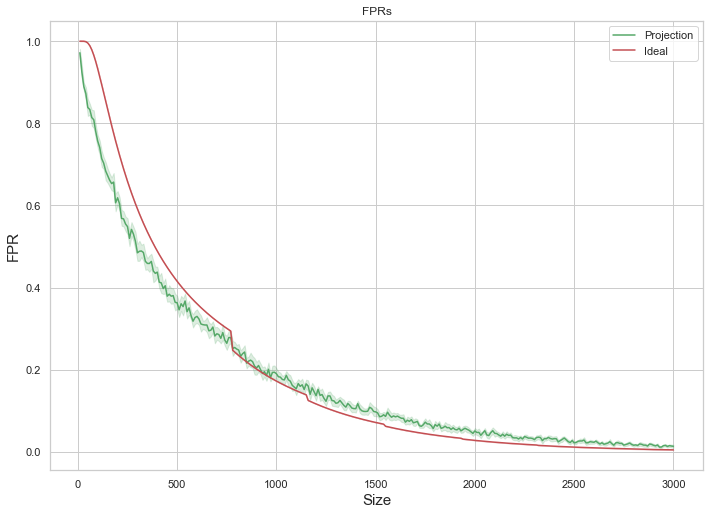

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [78]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [79]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [80]:
print(average_fprs)

[0.9718, 0.9250000000000002, 0.8892, 0.8726, 0.8384, 0.8336, 0.8140000000000001, 0.8085999999999999, 0.7796000000000001, 0.7564, 0.7409999999999999, 0.7140000000000001, 0.7027999999999999, 0.6838, 0.6727999999999998, 0.6613999999999999, 0.6532, 0.6567999999999999, 0.6064, 0.6186, 0.6035999999999999, 0.5684, 0.5671999999999999, 0.5548000000000001, 0.5484, 0.5198, 0.5416000000000001, 0.53, 0.5124000000000002, 0.4846000000000001, 0.48840000000000006, 0.48900000000000005, 0.4854000000000001, 0.4638000000000001, 0.45879999999999993, 0.4586, 0.4635999999999999, 0.4402000000000001, 0.4346, 0.4376000000000001, 0.4130000000000001, 0.4114, 0.3976, 0.40440000000000004, 0.37900000000000006, 0.38380000000000003, 0.379, 0.38040000000000007, 0.36400000000000005, 0.36299999999999993, 0.34580000000000005, 0.3605999999999999, 0.3536, 0.36719999999999997, 0.3412, 0.3505999999999999, 0.33199999999999996, 0.31799999999999995, 0.32699999999999996, 0.3298, 0.32339999999999997, 0.3111999999999999, 0.309600000

In [81]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.996,0.9718,0.108625,0.112259
1,20,0.999999,0.868,0.9250,0.088951,0.104290
2,30,0.999887,0.864,0.8892,0.162554,0.106985
3,40,0.998870,0.888,0.8726,0.086303,0.103798
4,50,0.995548,0.824,0.8384,0.084459,0.109729


In [32]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Diabetes_rerun_epochs_100.csv')